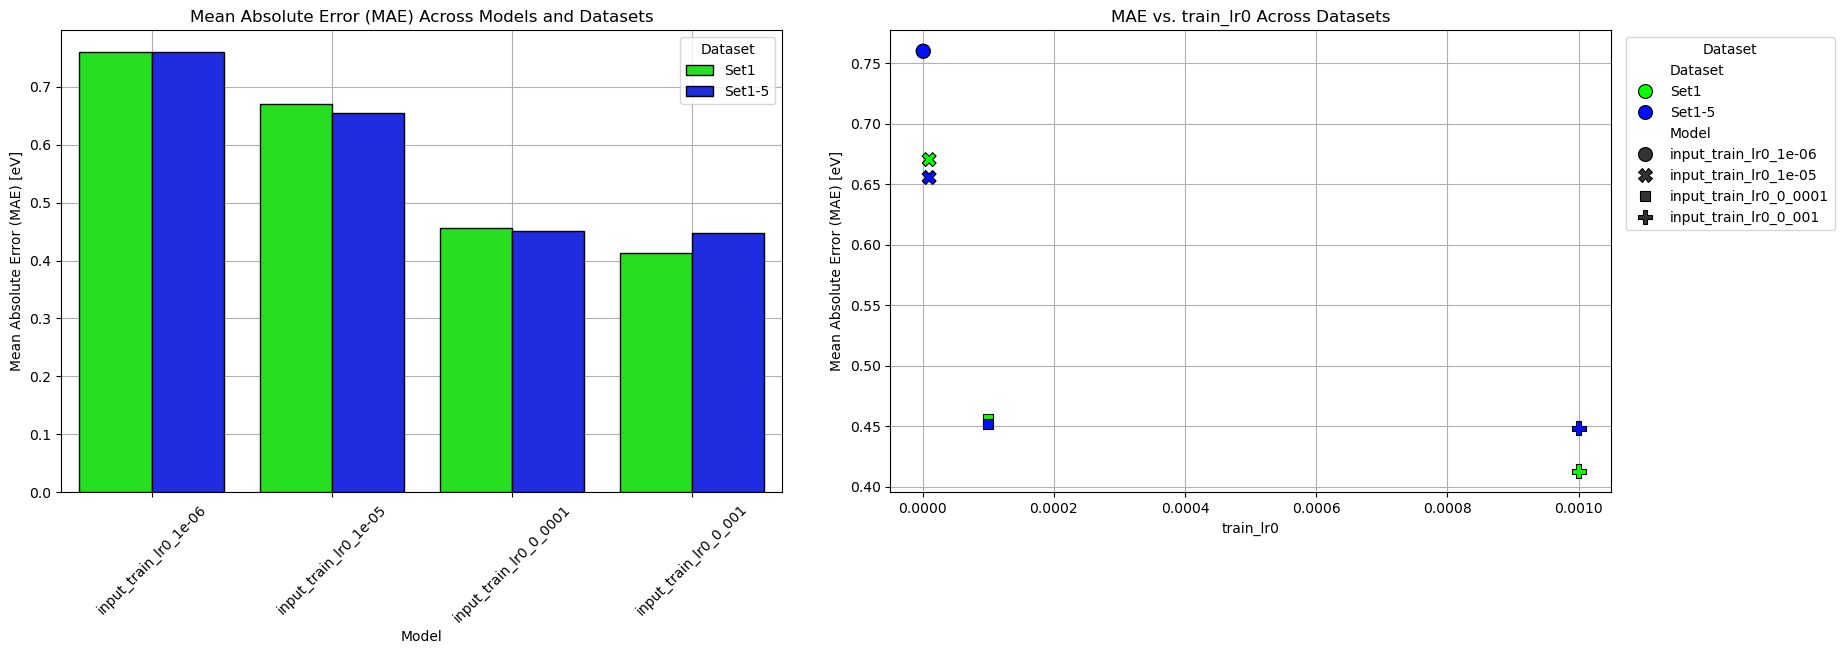

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast

root_dir = "/home/tvanhout/oxides_ML/models/hyperparameter_optimization"
datasets = ["Set1","Set1-5"]  # Add more dataset names as needed
QoI = "test_learning_rate"
independent_variable = 'train_lr0'

all_data = []

for dataset in datasets:
    parent_dir = os.path.join(root_dir, dataset, QoI)
    summary_data = []
    
    for model_folder in os.listdir(parent_dir):
        model_path = os.path.join(parent_dir, model_folder)
        
        if os.path.isdir(model_path):
            summary_entry = {'Dataset': dataset, 'Model': model_folder}

            # Load test set
            test_set_path = os.path.join(model_path, "test_set.csv")
            if os.path.exists(test_set_path):
                df_test = pd.read_csv(test_set_path)
                summary_entry['MAE'] = df_test['Abs_error_eV'].mean()

            # Load hyperparameters from .txt file
            hyperparam_path = os.path.join(model_path, "input.txt")
            if os.path.exists(hyperparam_path):
                with open(hyperparam_path, "r") as file:
                    hyperparams = ast.literal_eval(file.read())

                def flatten_dict(d, parent_key='', sep='_'):
                    items = []
                    for k, v in d.items():
                        new_key = f"{parent_key}{sep}{k}" if parent_key else k
                        if isinstance(v, dict):
                            items.extend(flatten_dict(v, new_key, sep=sep).items())
                        else:
                            items.append((new_key, v))
                    return dict(items)

                flat_hyperparams = flatten_dict(hyperparams)
                summary_entry.update(flat_hyperparams)

            summary_data.append(summary_entry)
    
    df_summary = pd.DataFrame(summary_data)
    all_data.append(df_summary)

# Combine all datasets into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

# Sorting
df_combined = df_combined.sort_values(["Dataset", independent_variable], ascending=True).reset_index()

# Plot MAE across datasets
plt.figure(figsize=(20, 6))

# First subplot
plt.subplot(1, 2, 1)
sns.barplot(data=df_combined, x='Model', y='MAE', hue='Dataset', palette='hsv', edgecolor='black', zorder=10)
plt.title('Mean Absolute Error (MAE) Across Models and Datasets')
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.xticks(rotation=45)
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_combined, x=independent_variable, y='MAE', hue='Dataset', style='Model', palette='hsv', s=100, edgecolor='black', zorder=10)
plt.xlabel(independent_variable)
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.title(f'MAE vs. {independent_variable} Across Datasets')
plt.legend(title='Dataset', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)

plt.subplots_adjust(wspace=0.15)
plt.show()


In [184]:
df_combined[["Dataset","Model","MAE"]]

,Dataset,Model,MAE
0,Set1,input_train_lr0_1e-06,0.759739
1,Set1,input_train_lr0_1e-05,0.670173
2,Set1,input_train_lr0_0_0001,0.456003
3,Set1,input_train_lr0_0_001,0.412714
4,Set1-5,input_train_lr0_1e-06,0.759704
5,Set1-5,input_train_lr0_1e-05,0.655399
6,Set1-5,input_train_lr0_0_0001,0.451574
7,Set1-5,input_train_lr0_0_001,0.448098
